<a href="https://colab.research.google.com/github/Computerglassformedandsurg/BRATS_SEGMENATION/blob/main/Brats_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before uploading the code in the github repository, create a new file in the repository


# Initiating new Kaggle API to download the Brats Data

In [24]:
!pip install -q kaggle

In [25]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jaisilrose","key":"2721ae88b2fc021680ffccc58b6122ad"}'}

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [00:51<00:01, 21.8MB/s]
100% 4.16G/4.16G [00:51<00:00, 86.3MB/s]


In [32]:
!unzip -q brats20-dataset-training-validation.zip -d /content/data

The below cells are to download datasets from kaggle and upload it into google colab and then to google drive as zip file.

Everytime we revisit, we just have to run the first part of cells which get the zip file containing data from the drive and unzip the folder into the google colab

# Installing and Importing libraries

In [34]:
!pip install nibabel

In [35]:
import numpy as np
import nibabel as nib
import os
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imwrite

from sklearn.preprocessing import MinMaxScaler

# Understanding the data

In [36]:
Train_data_path = "/content/data/BraTS2020_TrainingData/"
# loading nif file as npy

scaler = MinMaxScaler()


Apply Minmax scaler

reshapes the 3D data into a 2D matrix (combines all dimensions, keeping the last dimension as it is), applies the scaler, and then reshapes the data back to its original 3D shape.

In [37]:
#Flair Image
file_path = os.path.join(Train_data_path,'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_355','BraTS20_Training_355_flair.nii' )
test_image_flair = nib.load(file_path).get_fdata()
test_image_flair1 = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

Doing the same for all the slices of the example

In [40]:
# T1
file_path = os.path.join(Train_data_path,'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_355','BraTS20_Training_355_t1.nii' )
test_image_t1 = nib.load(file_path).get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# T1CE
file_path = os.path.join(Train_data_path,'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_355','BraTS20_Training_355_t1ce.nii' )
test_image_t1ce = nib.load(file_path).get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# T2
file_path = os.path.join(Train_data_path,'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_355','BraTS20_Training_355_t2.nii' )
test_image_t2 = nib.load(file_path).get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# Mask
file_path = os.path.join(Train_data_path,'MICCAI_BraTS2020_TrainingData', 'BraTS20_Training_355','BraTS20_Training_355_seg.nii' )
test_mask = nib.load(file_path).get_fdata()
test_mask = test_mask.astype(np.uint8)
test_mask[test_mask==4] = 3

View Random slice to view it

In [41]:
import random
n_slice = np.random.randint(0, test_mask.shape[2])

# # n_slice = 128 has mask
# n_slice = 128
print("slice no is:", n_slice)

slice no is: 103


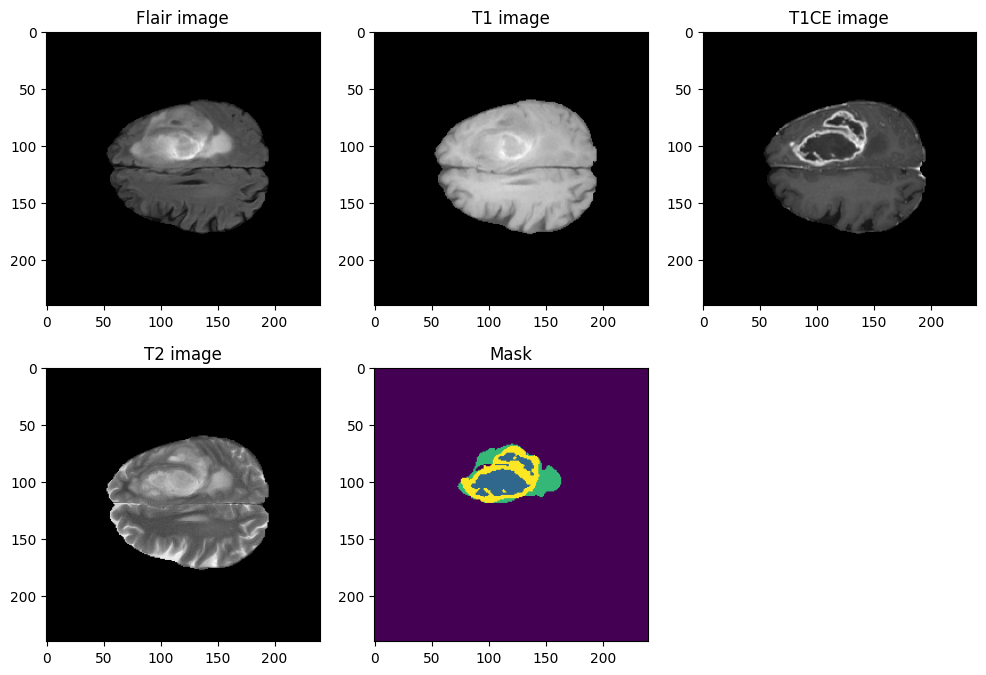

In [42]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:, :, n_slice], cmap= "gray")
plt.title("Flair image")

plt.subplot(232)
plt.imshow(test_image_t1[:, :, n_slice], cmap= "gray")
plt.title("T1 image")

plt.subplot(233)
plt.imshow(test_image_t1ce[:, :, n_slice], cmap= "gray")
plt.title("T1CE image")

plt.subplot(234)
plt.imshow(test_image_t2[:, :, n_slice], cmap= "gray")
plt.title("T2 image")

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title("Mask")

plt.show()



Combine the images as slices and divide them into patches

Note: Viewing the above images, Flair, T1CE and T2 has most information

In [43]:
# combine the image
combined_image = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

# Cropping the image to 128 x 128 x 128 x 3 to make it easier to divide them to patches of size 64 x 64
combined_cropped = combined_image[56:184, 56:184, 13:141]

#cropping mask to 128 x 128
test_mask = test_mask[56:184, 56:184, 13:141]

In [ ]:
print(test_image_flair.shape)
print(combined_image.shape)
print(combined_cropped.shape)



(240, 240, 155)
(240, 240, 155, 3)
(128, 128, 128, 3)


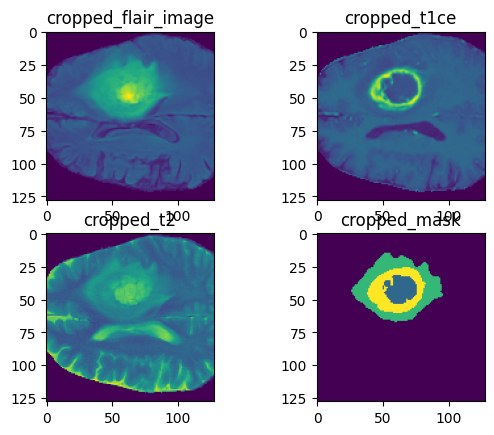

In [ ]:
# view the image
n_slice = np.random.randint(0, test_mask.shape[2])
# n_slice = 1

plt.subplot(221)
plt.imshow(combined_cropped[:,:,n_slice,0])
plt.title("cropped_flair_image")

plt.subplot(222)
plt.imshow(combined_cropped[:,:,n_slice,1])
plt.title("cropped_t1ce")

plt.subplot(223)
plt.imshow(combined_cropped[:,:,n_slice,2])
plt.title("cropped_t2")

plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title("cropped_mask")

plt.show()

Uncomment to save the images as tiff and npy. Also convert the mask to categorical(num of channels = num of classes)

*We are going to do this for all images.*

In [ ]:
# imwrite("/content/New_Data/combined355.tif", combined_cropped)
# np.save("/content/New_Data/combined355.npy", combined_cropped)
# test_mask = to_categorical(test_mask, num_classes=4)
# print(test_mask.shape)

(128, 128, 128, 4)


# Prepping the data...

**Store the list of the images in one list for each slices**

*This will make it easier to loop using forloop and combine each case into npy 3d multichannel volume*

In [44]:
t2_list = sorted(glob.glob('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))


In [45]:
print("total number of examples: ",len(mask_list))

total number of examples:  369


Loop in through each of these examples to combine and store it as npy 3D multichannel images.

Note: If the mask has less than 1% data, we are discarding the case. We are keeping a count of the useful data

Comment this to clear any folders

In [56]:
# !rm -rf /content/data/BraTS2020_TrainingData/input_data_3channels/images/*
# !rm -rf /content/data/BraTS2020_TrainingData/input_data_3channels/masks/*



In [59]:
# we are keeping the count of the images we are considering and the images that
#.. we are discarding
useful = 0
useless = 0

for img_no in range(9, len(t2_list)):
  print("Now prepping input images and mask no: ",img_no)

  temp_image_t2 = nib.load(t2_list[img_no]).get_fdata()
  temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

  temp_image_t1ce = nib.load(t1ce_list[img_no]).get_fdata()
  temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

  temp_image_flair = nib.load(flair_list[img_no]).get_fdata()
  temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

  temp_mask = nib.load(mask_list[img_no]).get_fdata()
  temp_mask = temp_mask.astype(np.uint8)
  temp_mask[temp_mask==4] = 3

  # Combine all of them!
  temp_combined = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

  # Crop the image and mask
  temp_combined_images=temp_combined[56:184, 56:184, 13:141]
  temp_mask = temp_mask[56:184, 56:184, 13:141]

  # Discard the less informative mask cases

  # Get the unique value and counts for each mask
  val, counts = np.unique(temp_mask, return_counts=True)

  # So the idea is to calaculate the percentage of non background pixels and discard the cases that has less than 1% of information
  if (1 - (counts[0]/counts.sum())) > 0.01:
    useful += 1
    temp_mask = to_categorical(temp_mask, num_classes = 4)
    np.save('/content/data/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img_no)+'.npy', temp_combined_images)


    np.save('/content/data/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img_no)+'.npy', temp_mask)
    # removing old mask as well


  else:
    useless += 1
    print("case no: ",img_no,"is useless")
  # # removing old images to save space
  !rm "{t2_list[img_no]}"
  !rm "{t1ce_list[img_no]}"
  !rm "{flair_list[img_no]}"
  !rm "{mask_list[img_no]}"








Now prepping input images and mask no:  9
Now prepping input images and mask no:  10
Now prepping input images and mask no:  11
Now prepping input images and mask no:  12
Now prepping input images and mask no:  13
Now prepping input images and mask no:  14
Now prepping input images and mask no:  15
Now prepping input images and mask no:  16
Now prepping input images and mask no:  17
Now prepping input images and mask no:  18
Now prepping input images and mask no:  19
Now prepping input images and mask no:  20
Now prepping input images and mask no:  21
Now prepping input images and mask no:  22
Now prepping input images and mask no:  23
Now prepping input images and mask no:  24
Now prepping input images and mask no:  25
Now prepping input images and mask no:  26
Now prepping input images and mask no:  27
case no:  27 is useless
Now prepping input images and mask no:  28
Now prepping input images and mask no:  29
Now prepping input images and mask no:  30
Now prepping input images and m

KeyboardInterrupt: 

In [63]:
!zip -r prepped_brats_file.zip /content/data/BraTS2020_TrainingData/input_data_3channels


  adding: content/data/BraTS2020_TrainingData/input_data_3channels/ (stored 0%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/ (stored 0%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_20.npy (deflated 58%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_114.npy (deflated 47%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_49.npy (deflated 47%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_19.npy (deflated 51%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_106.npy (deflated 49%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_111.npy (deflated 44%)
  adding: content/data/BraTS2020_TrainingData/input_data_3channels/images/image_40.npy (deflated 47%)
  adding: content

In [47]:
print()

/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii


# Please open and read this before going further

# Get the zip file from local drive and unzip it to google colab

In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

# from google.colab import files

# uploaded = files.upload()



In [ ]:
# only uncomment this if you are uploading the file from drive
# import shutil

# source_path = '/content/drive/MyDrive/Colab Notebooks/brats20-dataset-training-validation.zip'
# destination_path = "/content/"

# # Move the zip file from drive to colab
# shutil.move(source_path, destination_path)

# print(f"'{source_path}' moved to Drive at '{destination_path}'")


# q for quietly unzipping file suppressing the verbose list
!unzip -q brats20-dataset-training-validation(1).zip -d /content/data

'/content/drive/MyDrive/Colab Notebooks/brats20-dataset-training-validation.zip' moved to Drive at '/content/'


# Saving the zip file containing data in the google drive




In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import shutil

# source_path = '/content/brats20-dataset-training-validation.zip'
# destination_path = '/content/drive/My Drive/Colab Notebooks/brats20-dataset-training-validation.zip'

# # Move the file
# shutil.move(source_path, destination_path)

# print(f"'{source_path}' moved to Drive at '{destination_path}'")

'/content/brats20-dataset-training-validation.zip' moved to Drive at '/content/drive/My Drive/Colab Notebooks/brats20-dataset-training-validation.zip'


# Acknowledgement

***References***

*   **Code:**https://github.com/bnsreenu/python_for_microscopists/tree/master/231_234_BraTa2020_Unet_segmentation
* **Video:**https://www.youtube.com/watch?v=oB35sV1npVI&list=PLZsOBAyNTZwYgF8O1bTdV-lBdN55wLHDr&index=2